# Mini Project - Train a VAE to Generate Faces Using the CelebA Dataset

This program builds and trains a Variational Autoencoder (VAE) on the CelebA dataset. A VAE is a type of generative model that learns a compressed, probabilistic representation (latent space) of the input data. After training, it can generate new, realistic-looking faces by sampling from this learned latent space.

In [1]:
!pip install tensorflow tensorflow_datasets

we import the necessary libraries and load the CelebA dataset. We also define a preprocessing function to crop, resize, and normalize the images for consistent model input

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# --- Data Loading and Preprocessing ---

def preprocess_image(data):
    """Crops, resizes, and normalizes the image."""
    image = data['image']
    # Crop the image to focus on the face (empirically determined values)
    image = tf.image.crop_to_bounding_box(image, 38, 18, 140, 140)
    # Resize to a standard 64x64
    image = tf.image.resize(image, [64, 64])
    # Normalize pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Load the CelebA dataset
(ds_train, ds_test), ds_info = tfds.load(
    'celeb_a',
    split=['train', 'test'],
    with_info=True,
    as_supervised=False,
    shuffle_files=True
)

# Create batched datasets for training and testing
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = ds_train.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(ds_info.splits['train'].num_examples).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = ds_test.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/incomplete.LS6DDH_2.1.0/celeb_a-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/incomplete.LS6DDH_2.1.0/celeb_a-validation.tfrecord*...:   0%|    …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/incomplete.LS6DDH_2.1.0/celeb_a-test.tfrecord*...:   0%|          …

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.1.0. Subsequent calls will reuse this data.


# VAE Model Architecture
A VAE consists of an Encoder, a Decoder, and a special Sampling layer that introduces the probabilistic nature of the model using the "reparameterization trick."

The Encoder maps an input image to a latent probability distribution (mean and log-variance).

The Sampling layer uses this distribution to generate a random latent vector.

The Decoder takes this latent vector and reconstructs an image from it.

In [3]:
LATENT_DIM = 100
IMAGE_SHAPE = (64, 64, 3)

# --- Sampling Layer (Reparameterization Trick) ---
class Sampling(layers.Layer):
    """Samples from the latent space distribution using (z_mean, z_log_var)."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- Encoder Network ---
encoder_inputs = layers.Input(shape=IMAGE_SHAPE)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# --- Decoder Network ---
latent_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,097,280 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │     12,900 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 100)       │     12,900 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 100)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,142,472 (8.17 MB)

 Trainable params: 2,142,472 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16384)          │     1,654,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,711,043 (6.53 MB)

 Trainable params: 1,711,043 (6.53 MB)

 Non-trainable params: 0 (0.00 B)

# VAE Model with Custom Training Step
We combine the encoder and decoder into a single VAE model. The training logic is customized to include both a reconstruction loss (how well the decoder reconstructs the original image) and a Kullback-Leibler (KL) divergence loss (which ensures the latent space is well-formed and continuous).

In [4]:
# --- VAE Model with Custom Training Logic ---
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Get latent space parameters and sample vector z
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruct the image from the latent vector
            reconstruction = self.decoder(z)

            # Calculate reconstruction loss (how different is the output from the input?)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            # Calculate KL divergence loss (how different is the latent distribution from a standard normal?)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total loss is a combination of both
            total_loss = recon_loss + kl_loss

        # Apply gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update and return loss metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Training the VAE
Now we can instantiate our VAE, compile it with an optimizer, and train it on the CelebA dataset.

In [5]:
# --- Train the VAE ---
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Train for 20 epochs
history = vae.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
 367/1272 ━━━━━━━━━━━━━━━━━━━━ 18:00 1s/step - kl_loss: 11.9160 - loss: 2616.1284 - recon_loss: 2604.2124

KeyboardInterrupt: 

# Generating New Faces
After training, the decoder is now a powerful generative tool. We can feed it random vectors sampled from a standard normal distribution to generate entirely new, unique faces that resemble the training data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


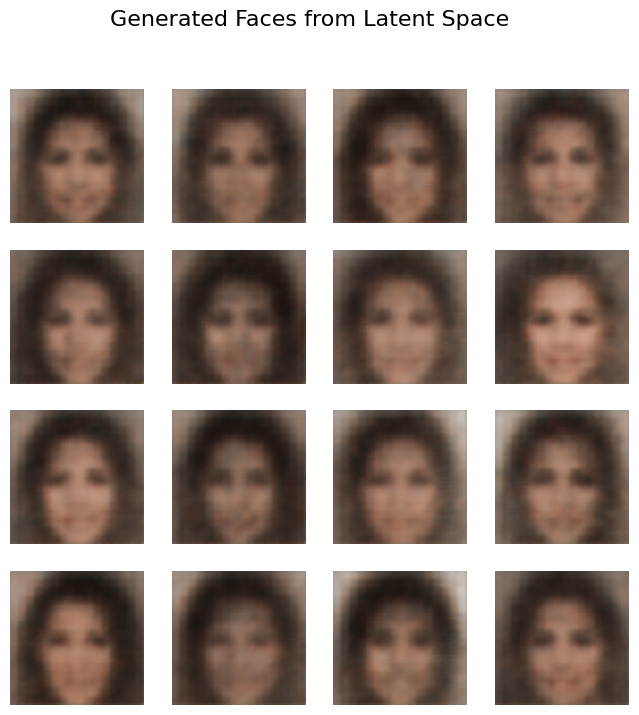

In [6]:
# --- Function to Generate and Display Images ---
def generate_and_show_faces(decoder, num_faces=16):
    # Sample random points from the latent space (a standard normal distribution)
    random_latent_vectors = np.random.normal(size=(num_faces, LATENT_DIM))

    # Decode these vectors into images
    generated_images = decoder.predict(random_latent_vectors)

    # Plot the results
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle("Generated Faces from Latent Space", fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i])
        ax.axis("off")
    plt.show()

# --- Generate and show new faces ---
generate_and_show_faces(decoder, num_faces=16)